In [2]:
import sys
!{sys.executable} -m pip install bs4
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install ta
!{sys.executable} -m pip install finta
!{sys.executable} -m pip install mplfinance
!{sys.executable} -m pip install yfinance

     |████████████████████████████████| 97 kB 4.0 MB/s eta 0:00:011
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1271 sha256=c495dfa75addda7380e0be5d6ebe98378ae0f01f34a97b65381baee5a97d7da7
  Stored in directory: /Users/manueltellechea/Library/Caches/pip/wheels/75/78/21/68b124549c9bdc94f822c02fb9aa3578a669843f9767776bca
Successfully built bs4
  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28718 sha256=392cd05b993818752470e593f35f20ab630c54f85b95d7409b8245cc7b9b2348
  Stored in directory: /Users/manueltellechea/Library/Caches/pip/wheels/bb/7c/a0/9c72e50ddef1f7c3d9003bf4ccc5d5c8deb24828d4eb156fc8
Successfully built ta
     |████████████████████████████████| 62 kB 2.1 MB/s eta 0:00:011
     |████████████████████████████████| 7.2 MB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 539 kB/s  eta 0:00:01
     |████████████████████████████████| 3.0 MB 11.5 MB/s eta 0:00:01     |██████████▌                     | 993 kB 11.5 MB/s eta 0:00

In [2]:
import matplotlib.pyplot as plt
import warnings
import requests
import time
import math
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from bs4 import BeautifulSoup
import mplfinance as mpf

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
screened_list = []
stock_list = ['AAPL','TSLA','FL','BA']
for stock_code in stock_list:
  # get stock prices
  df = yf.download(stock_code, start='2020-01-01', threads= False)

  # parameter setup
  length = 20
  mult = 2
  length_KC = 20
  mult_KC = 1.5

  # calculate BB
  m_avg = df['Close'].rolling(window=length).mean()
  m_std = df['Close'].rolling(window=length).std(ddof=0)
  df['upper_BB'] = m_avg + mult * m_std
  df['lower_BB'] = m_avg - mult * m_std

  # calculate true range
  df['tr0'] = abs(df["High"] - df["Low"])
  df['tr1'] = abs(df["High"] - df["Close"].shift())
  df['tr2'] = abs(df["Low"] - df["Close"].shift())
  df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)

  # calculate KC
  range_ma = df['tr'].rolling(window=length_KC).mean()
  df['upper_KC'] = m_avg + range_ma * mult_KC
  df['lower_KC'] = m_avg - range_ma * mult_KC

  # calculate bar value
  highest = df['High'].rolling(window = length_KC).max()
  lowest = df['Low'].rolling(window = length_KC).min()
  m1 = (highest + lowest)/2
  df['value'] = (df['Close'] - (m1 + m_avg)/2)
  fit_y = np.array(range(0,length_KC))
  df['value'] = df['value'].rolling(window = length_KC).apply(lambda x: 
                            np.polyfit(fit_y, x, 1)[0] * (length_KC-1) + 
                            np.polyfit(fit_y, x, 1)[1], raw=True)

  # check for 'squeeze'
  df['squeeze_on'] = (df['lower_BB'] > df['lower_KC']) & (df['upper_BB'] < df['upper_KC'])
  df['squeeze_off'] = (df['lower_BB'] < df['lower_KC']) & (df['upper_BB'] > df['upper_KC'])

  # buying window for long position:
  # 1. black cross becomes gray (the squeeze is released)
  long_cond1 = (df['squeeze_off'][-2] == False) & (df['squeeze_off'][-1] == True) 
  # 2. bar value is positive => the bar is light green k
  long_cond2 = df['value'][-1] > 0
  enter_long = long_cond1 and long_cond2

  # buying window for short position:
  # 1. black cross becomes gray (the squeeze is released)
  short_cond1 = (df['squeeze_off'][-2] == False) & (df['squeeze_off'][-1] == True) 
  # 2. bar value is negative => the bar is light red 
  short_cond2 = df['value'][-1] < 0
  enter_short = short_cond1 and short_cond2

  if enter_long | enter_short:
      screened_list.append(stock_code)

if screened_list:
  print(screened_list)
else:
  print('No stock fits the Squeeze Momentum Indicator entry requirement')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
['AAPL']


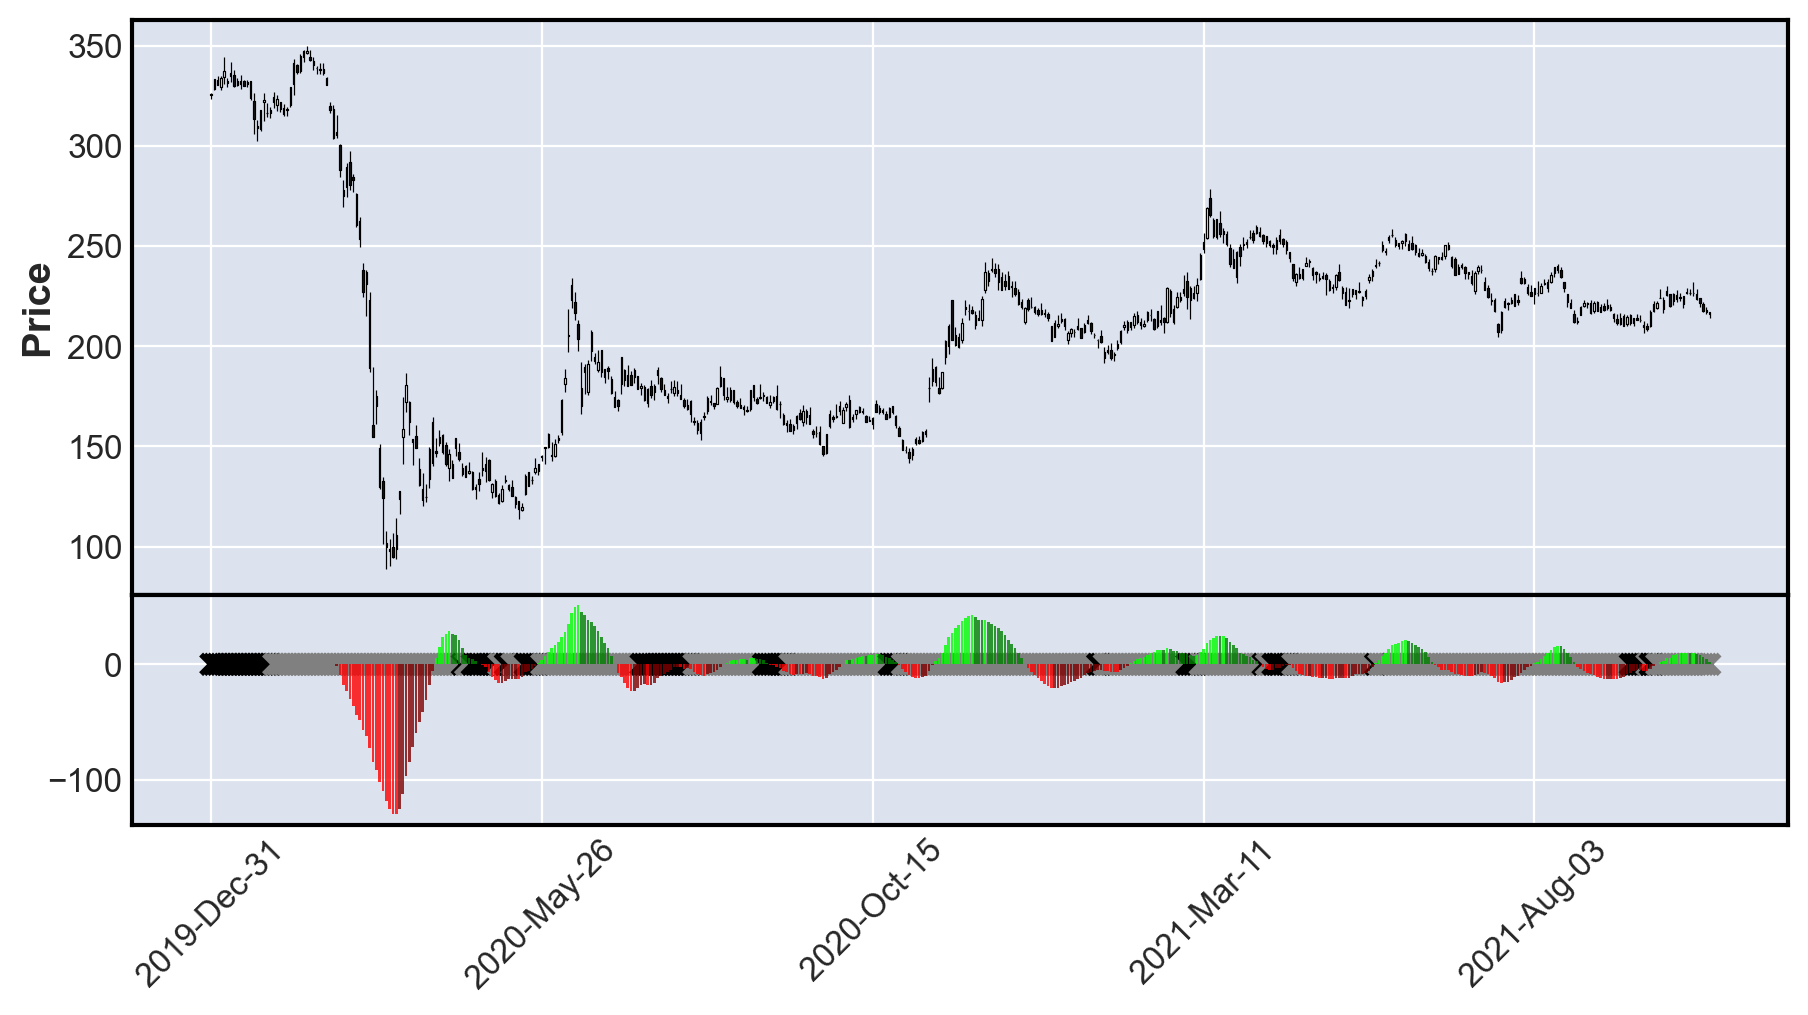

In [4]:
# to make the visualization better by only taking the last 100 rows of data
df = df[-1500:]

# extract only ['Open', 'High', 'Close', 'Low'] from df
ohcl = df[['Open', 'High', 'Close', 'Low']]

# add colors for the 'value bar'
colors = []
for ind, val in enumerate(df['value']):
  if val >= 0:
    color = 'green'
    if val > df['value'][ind-1]:
      color = 'lime'
  else:
    color = 'maroon'
    if val < df['value'][ind-1]:
      color='red'
  colors.append(color)
  
# add 2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df), panel=1, type='scatter', marker='x', markersize=50, color=['gray' if s else 'black' for s in df['squeeze_off']], secondary_y=False)]

# plot ohcl with subplots
fig, axes = mpf.plot(ohcl, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1, 
              type='candle', 
              addplot=apds,
              returnfig=True)